### 90803 Final Project

# Q3: Unsupervised Learning/Clustering for Cities

**Team 14**

Chi-Shiun Tsai & Colton Lapp

**Overview**

This notebook contains the code for our unsupervised learning/clustering analysis of cities. 
Our main research question is ***What are some ways we can cluster cities into categories based on all available data, and will this reveal any patterns about city development?***

Here are the steps we took to answer this question:

**City size definition**
We understand that the nature of cities is different based on their population size. Therefore, we divided the cities into 3 groups based on their population size: small, medium, and large, as we did in question 1. We then performed clustering analysis on each group of cities separately.

**Data Transformation**
We used the same data transformation process as we did in question 1. We first take the log of skewed variables, then standardize all variables using robust scaler. 

**Models**
We used 4 different clustering models to cluster the cities. 2 of the models are taught in class (K-means clustering and hierarchical clustering), and we found 2 models that might be useful for our analysis in terms of finding non-spherical clusters (DBSCAN and Gaussian Mixture Model).
The models we used and the methods we used to determine the optimal number of clusters and related parameters are as follows:
1. ***K-means clustering***: we used the elbow method to determine the optimal number of clusters for each group of cities.
2. ***Hierarchical clustering***: we used the dendrogram to determine the optimal number of clusters for each group of cities.
3. ***DBSCAN***: we used the elbow method to determine the optimal number of eps for each group of cities.
4. ***Gaussian Mixture Model***: we used the Bayesian Information Criterion (BIC) to determine the optimal number of clusters for each group of cities.

**Conclusion and Future Work**
See bottom of the notebook.

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import RobustScaler, PowerTransformer
import geopandas as gpd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
import scipy as sp
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance
from sklearn.decomposition import PCA

%matplotlib inline
pd.set_option('display.max_columns', 500)

#### Set Seed

In [2]:
seed = 0

### Read in Data

In [3]:
#Set Base Dir
base_dir = os.getcwd().split('/')
base_dir = '/'.join(base_dir[0:-1])
base_dir
df = pd.read_csv(base_dir + '/Team14_CL_CT_MG/data/data_all.csv', low_memory=False)
df.head(3)

,Name,Population 2020,Median Household Income,Median Home Value,Median Gross Rent,Renter Household,Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 15 or Older Never Married 2,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Took Public Transportation to work,Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,Employed in Professional/Scientific/Technical Services,Employed in Accommodation/Food Services,Employed in Health Care/Social Assistance,Employed in Arts/Entertainment/Recreation,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households with No Internet Acces,Households Receiving Food Stamps/SNAP,Households Below the Poverty Leve,Gross Rent 50% + of Household Income,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,state,place,GEOID,Population 2019,Pop Chng %,land_area,water_area,cases_per_100K,deaths_per_100K
0,"New York city, New York",8379552,67046.0,635200.0,1489.0,2143429.0,42.002186,41.330205,28.925997,16.000569,1.125072,7.664813,17.610035,18.069295,14.947255,4.979001,1.908419,46.830821,24.736883,3.465794,10.448387,4.848242,3.531358,8.708186,1.403011,1.143271,1.902047,1.705306,8.383276,3.427486,5.030627,7.244218,6.556830,6.763679,0.208245,3.913145,0.719466,36,51000,3651000,8419316,-0.472295,777982727,434642000,5913.616647,220.640533
1,"Los Angeles city, California",3973278,65290.0,670700.0,1523.0,884176.0,38.099297,48.930480,48.066307,16.225771,1.007329,5.683670,19.986897,17.982834,12.855557,3.889962,1.788574,49.252959,4.056122,4.517605,33.341664,4.703748,4.288298,6.098239,2.086111,1.660996,1.278365,2.068393,7.988391,5.480588,3.824172,3.640193,5.838303,6.734288,0.256715,2.800433,0.887101,6,44000,644000,3966936,0.159871,1214591312,87468461,6178.068445,67.066531
2,"Chicago city, Illinois",2699347,62097.0,267600.0,1154.0,590848.0,45.110392,47.731581,28.628813,16.758127,1.200438,8.816058,20.245897,19.983537,12.676177,4.820647,1.800250,49.382610,12.919050,4.194570,23.775417,6.130186,4.004228,7.006176,1.199698,1.064406,2.110918,2.475895,5.359926,4.764597,5.445095,7.012289,6.614933,5.035996,0.455777,5.058372,0.868655,17,14000,1714000,2709534,-0.375969,588881854,17621529,7499.869841,133.847542


## Set Up Data

### Adjust Row Names
Note: If we want to include state effects, we could keep that column and create boolean values out of it

In [4]:
#Set row equal to name
df.set_index('Name', inplace=True, drop=True)

#Drop GEOID and STATE column
df = df.drop( ['GEOID', 'state'], axis=1)
df.head(3)

,Population 2020,Median Household Income,Median Home Value,Median Gross Rent,Renter Household,Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 15 or Older Never Married 2,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Took Public Transportation to work,Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,Employed in Professional/Scientific/Technical Services,Employed in Accommodation/Food Services,Employed in Health Care/Social Assistance,Employed in Arts/Entertainment/Recreation,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households with No Internet Acces,Households Receiving Food Stamps/SNAP,Households Below the Poverty Leve,Gross Rent 50% + of Household Income,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,place,Population 2019,Pop Chng %,land_area,water_area,cases_per_100K,deaths_per_100K
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"New York city, New York",8379552,67046.0,635200.0,1489.0,2143429.0,42.002186,41.330205,28.925997,16.000569,1.125072,7.664813,17.610035,18.069295,14.947255,4.979001,1.908419,46.830821,24.736883,3.465794,10.448387,4.848242,3.531358,8.708186,1.403011,1.143271,1.902047,1.705306,8.383276,3.427486,5.030627,7.244218,6.556830,6.763679,0.208245,3.913145,0.719466,51000,8419316,-0.472295,777982727,434642000,5913.616647,220.640533
"Los Angeles city, California",3973278,65290.0,670700.0,1523.0,884176.0,38.099297,48.930480,48.066307,16.225771,1.007329,5.683670,19.986897,17.982834,12.855557,3.889962,1.788574,49.252959,4.056122,4.517605,33.341664,4.703748,4.288298,6.098239,2.086111,1.660996,1.278365,2.068393,7.988391,5.480588,3.824172,3.640193,5.838303,6.734288,0.256715,2.800433,0.887101,44000,3966936,0.159871,1214591312,87468461,6178.068445,67.066531
"Chicago city, Illinois",2699347,62097.0,267600.0,1154.0,590848.0,45.110392,47.731581,28.628813,16.758127,1.200438,8.816058,20.245897,19.983537,12.676177,4.820647,1.800250,49.382610,12.919050,4.194570,23.775417,6.130186,4.004228,7.006176,1.199698,1.064406,2.110918,2.475895,5.359926,4.764597,5.445095,7.012289,6.614933,5.035996,0.455777,5.058372,0.868655,14000,2709534,-0.375969,588881854,17621529,7499.869841,133.847542


## Final data cleaning

In [5]:
#Drop rows with infinite growth rates
starting_rows = df.shape[0]

# Find the indices of positive or negative infinity
inf_indices = np.isinf(df['Pop Chng %'])

# Drop rows
df = df[~inf_indices]

# Replace the missing value code from census data
df = df.replace(-666666666, np.nan)

#Forgot to normalize renter HH by population 
df['Renter Household'] = df['Renter Household']/df['Population 2020']

# Add the two never married columns together
df['Population Age 15 or Older Never Married'] = df['Population Age 15 or Older Never Married'] + df['Population Age 15 or Older Never Married 2']
df.drop(['Population Age 15 or Older Never Married 2'], axis=1, inplace=True)

#Drop rows with NaN
df = df.dropna()

print("Went from {} rows to {} rows after cleaning".format(starting_rows, df.shape[0]))

Went from 19495 rows to 16665 rows after cleaning


Categorize cities based on population size (same as what we did for Q1)

In [6]:
# Set cutoff points
small_cut = 5000
med_cut = 50000

# Create variable to classify city as small/medium/large
def class_city(row):
    if row['Population 2020'] < small_cut:
        return "small"
    elif row['Population 2020'] < med_cut:
        return "medium"
    else:
        return "big"
    
# Create new 'size' column using the apply function
df['City_Size'] = df.apply(lambda row: class_city(row), axis=1)  

# Get the counts of each size
df['City_Size'].value_counts()

small     11920
medium     3970
big         775
Name: City_Size, dtype: int64

We will run clustering for each size category.

# Data Transformations

### Take Log of skewed variables


In [7]:
cols_original = df.columns.values
cols_new = list(cols_original)
vars_not_to_log  = ['Renter Household', 'Race: White Alone', "Hispanic or Latino",
                    'Population Age 25 or Older: Bachelor`s Degree','Pop 5-17 Speak only English at Home',
                    'Population Age 15 or Older Never Married', 'Pop Chng %',
                    'Females 20-64 w Own Children 0-17', 'Workers Age 16 or more', 'Workers 16 or more who Drove Alone to Work', 'City_Size']


df_logged = df.copy()

for col in df_logged.columns:
    if col not in vars_not_to_log:
        log_name = "log " + col
        df_logged[log_name] =  np.log(df_logged[col] + .1)
        df_logged.drop(col, axis=1, inplace=True)
        
        ii = cols_new.index(col)
        cols_new =cols_new[:ii]+ ["log " + col]+ cols_new[ii+1:]

df_logged = df_logged[cols_new]
df_logged.head(3)

,log Population 2020,log Median Household Income,log Median Home Value,log Median Gross Rent,Renter Household,log Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,log Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,log Population Age 65 or more,log Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,log Workers 16 or more who Took Public Transportation to work,log Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,log Employed in Professional/Scientific/Technical Services,log Employed in Accommodation/Food Services,log Employed in Health Care/Social Assistance,log Employed in Arts/Entertainment/Recreation,log Male 16+: Private For-Profit Self-Emp Inc Bus,log Male 16+: Private Not-For-Profit Worker,log Civilian Population 18+: Veteran,log Population 35-64: Medicaid Coverage Only,log Population 35-64: No Health Insurance Coverage,log Households with No Internet Acces,log Households Receiving Food Stamps/SNAP,log Households Below the Poverty Leve,log Gross Rent 50% + of Household Income,log Owner Households by Year Moved In: 2017 or Later,log Total Vacant Housing Units,log Housing Units Built in 2014 or Later,log place,log Population 2019,Pop Chng %,log land_area,log water_area,log cases_per_100K,log deaths_per_100K,City_Size
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"New York city, New York",15.941305,11.113136,13.361695,7.305927,0.255793,3.740100,41.330205,28.925997,16.000569,0.203000,7.664813,35.679330,2.711196,1.625115,1.908419,46.830821,3.212330,1.271387,10.448387,1.599032,1.289607,2.175682,0.407470,0.217746,0.694170,0.590730,2.138097,1.260586,1.635228,1.993913,1.895643,1.926244,-1.176860,1.389575,-0.199103,10.839583,15.946039,-0.472295,20.472215,19.890033,8.685030,5.396988,big
"Los Angeles city, California",15.195102,11.086596,13.416077,7.328503,0.222531,3.642817,48.930480,48.066307,16.225771,0.101951,5.683670,37.969732,2.561525,1.383782,1.788574,49.252959,1.424582,1.529876,33.341664,1.569397,1.478941,1.824265,0.782124,0.565880,0.320898,0.773986,2.090430,1.719294,1.367155,1.319137,1.781423,1.921952,-1.030818,1.064860,-0.012983,10.691947,15.193505,0.159871,20.917673,18.286789,8.728777,4.207175,big
"Chicago city, Illinois",14.808520,11.036455,12.497249,7.051076,0.218886,3.811327,47.731581,28.628813,16.758127,0.262701,8.816058,40.229433,2.547582,1.593440,1.800250,49.382610,2.566414,1.457351,23.775417,1.829406,1.412018,1.960964,0.262132,0.152211,0.793408,0.946197,1.697435,1.581984,1.712914,1.961824,1.904334,1.636274,-0.587388,1.640621,-0.031847,9.546820,14.812287,-0.375969,20.193736,16.684632,8.922654,4.897448,big


In [8]:
df_logged_scaled = df_logged.copy()

# create a RobustScaler object
scaler = RobustScaler()

# select only numeric columns
num_cols = df_logged_scaled.select_dtypes(include=['int', 'float']).columns

# fit and transform the scaler on the numeric columns
df_logged_scaled[num_cols] = scaler.fit_transform(df_logged_scaled[num_cols])

df_logged_scaled.head()

,log Population 2020,log Median Household Income,log Median Home Value,log Median Gross Rent,Renter Household,log Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,log Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,log Population Age 65 or more,log Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,log Workers 16 or more who Took Public Transportation to work,log Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,log Employed in Professional/Scientific/Technical Services,log Employed in Accommodation/Food Services,log Employed in Health Care/Social Assistance,log Employed in Arts/Entertainment/Recreation,log Male 16+: Private For-Profit Self-Emp Inc Bus,log Male 16+: Private Not-For-Profit Worker,log Civilian Population 18+: Veteran,log Population 35-64: Medicaid Coverage Only,log Population 35-64: No Health Insurance Coverage,log Households with No Internet Acces,log Households Receiving Food Stamps/SNAP,log Households Below the Poverty Leve,log Gross Rent 50% + of Household Income,log Owner Households by Year Moved In: 2017 or Later,log Total Vacant Housing Units,log Housing Units Built in 2014 or Later,log place,log Population 2019,Pop Chng %,log land_area,log water_area,log cases_per_100K,log deaths_per_100K,City_Size
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"New York city, New York",3.624138,0.576553,2.097412,1.653279,1.635452,-0.318611,-2.530708,2.758687,0.997219,0.675130,-1.096272,1.369148,-0.302791,-0.162099,-0.042021,0.152408,3.759130,0.474457,-2.553245,0.817089,0.272184,0.561224,0.365696,0.314456,0.537086,-1.988486,0.819750,0.052513,-0.213752,0.388055,0.269285,0.940607,-0.154303,-0.223980,0.246387,0.183494,3.605278,-0.101703,2.691346,0.714814,-0.243847,0.960094,big
"Los Angeles city, California",3.306131,0.519098,2.165311,1.709109,1.231243,-0.708170,-2.135390,4.871871,1.027335,0.626088,-1.393215,1.613933,-0.611178,-0.496530,-0.115254,0.379049,2.540548,0.666381,-0.268427,0.797555,0.479498,-0.067448,0.516846,0.540147,0.238820,-1.679334,0.780508,0.461666,-0.520698,-0.221204,0.145730,0.937334,-0.087944,-0.505631,0.318282,0.048612,3.286862,-0.008355,2.927408,0.603250,-0.144416,-0.517855,big
"Chicago city, Illinois",3.141383,0.410550,1.018102,1.023038,1.186947,-0.033387,-2.197749,2.725876,1.098528,0.704106,-0.923717,1.855438,-0.639906,-0.205993,-0.108119,0.391180,3.318854,0.612533,-1.223167,0.968937,0.406219,0.177102,0.307061,0.271971,0.616383,-1.388815,0.456966,0.339190,-0.124801,0.359082,0.278685,0.719390,0.113543,-0.006228,0.310995,-0.997589,3.125560,-0.087479,2.543771,0.491761,0.296237,0.339581,big
"Houston city, Texas",3.075599,0.091995,0.569303,0.872861,1.151612,-0.273297,-1.999697,4.475036,0.672988,0.675685,-1.039067,1.004736,-0.932315,-0.605667,0.205911,0.232441,1.988287,0.355922,0.017546,0.706981,0.379279,-0.278616,0.124711,0.210406,0.126515,-1.085200,-0.114012,0.997301,-0.174980,0.125746,0.270372,0.744655,0.075322,-0.075390,0.711080,-0.160459,3.058139,-0.014028,3.092355,0.598117,-0.629083,-0.704889,big
"Phoenix city, Arizona",2.933779,0.368909,0.937149,0.904534,0.418083,-0.739073,-1.131387,4.273558,0.456140,0.500300,-0.596011,0.827527,-0.934436,-0.642860,0.362118,0.344294,1.811297,0.589014,-0.040566,0.623335,0.460832,-0.086986,0.211307,0.315140,0.207753,-0.441910,0.413457,0.598897,-0.487422,-0.083628,-0.063953,0.402678,0.282803,-0.511076,0.398342,0.252478,2.911313,0.197762,2.979783,0.373843,0.237074,0.163452,big


## Create Dataset for Each Size Category

In [9]:
df_small = df_logged_scaled[df_logged_scaled['City_Size'] == 'small']
X_small = df_small.drop(['City_Size'], axis=1)

df_medium = df_logged_scaled[df_logged_scaled['City_Size'] == 'medium']
X_medium = df_medium.drop(['City_Size'], axis=1)

df_big = df_logged_scaled[df_logged_scaled['City_Size'] == 'big']
X_big = df_big.drop(['City_Size'], axis=1)

X_big.head(5)

,log Population 2020,log Median Household Income,log Median Home Value,log Median Gross Rent,Renter Household,log Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,log Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,log Population Age 65 or more,log Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,log Workers 16 or more who Took Public Transportation to work,log Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,log Employed in Professional/Scientific/Technical Services,log Employed in Accommodation/Food Services,log Employed in Health Care/Social Assistance,log Employed in Arts/Entertainment/Recreation,log Male 16+: Private For-Profit Self-Emp Inc Bus,log Male 16+: Private Not-For-Profit Worker,log Civilian Population 18+: Veteran,log Population 35-64: Medicaid Coverage Only,log Population 35-64: No Health Insurance Coverage,log Households with No Internet Acces,log Households Receiving Food Stamps/SNAP,log Households Below the Poverty Leve,log Gross Rent 50% + of Household Income,log Owner Households by Year Moved In: 2017 or Later,log Total Vacant Housing Units,log Housing Units Built in 2014 or Later,log place,log Population 2019,Pop Chng %,log land_area,log water_area,log cases_per_100K,log deaths_per_100K
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"New York city, New York",3.624138,0.576553,2.097412,1.653279,1.635452,-0.318611,-2.530708,2.758687,0.997219,0.675130,-1.096272,1.369148,-0.302791,-0.162099,-0.042021,0.152408,3.759130,0.474457,-2.553245,0.817089,0.272184,0.561224,0.365696,0.314456,0.537086,-1.988486,0.819750,0.052513,-0.213752,0.388055,0.269285,0.940607,-0.154303,-0.223980,0.246387,0.183494,3.605278,-0.101703,2.691346,0.714814,-0.243847,0.960094
"Los Angeles city, California",3.306131,0.519098,2.165311,1.709109,1.231243,-0.708170,-2.135390,4.871871,1.027335,0.626088,-1.393215,1.613933,-0.611178,-0.496530,-0.115254,0.379049,2.540548,0.666381,-0.268427,0.797555,0.479498,-0.067448,0.516846,0.540147,0.238820,-1.679334,0.780508,0.461666,-0.520698,-0.221204,0.145730,0.937334,-0.087944,-0.505631,0.318282,0.048612,3.286862,-0.008355,2.927408,0.603250,-0.144416,-0.517855
"Chicago city, Illinois",3.141383,0.410550,1.018102,1.023038,1.186947,-0.033387,-2.197749,2.725876,1.098528,0.704106,-0.923717,1.855438,-0.639906,-0.205993,-0.108119,0.391180,3.318854,0.612533,-1.223167,0.968937,0.406219,0.177102,0.307061,0.271971,0.616383,-1.388815,0.456966,0.339190,-0.124801,0.359082,0.278685,0.719390,0.113543,-0.006228,0.310995,-0.997589,3.125560,-0.087479,2.543771,0.491761,0.296237,0.339581
"Houston city, Texas",3.075599,0.091995,0.569303,0.872861,1.151612,-0.273297,-1.999697,4.475036,0.672988,0.675685,-1.039067,1.004736,-0.932315,-0.605667,0.205911,0.232441,1.988287,0.355922,0.017546,0.706981,0.379279,-0.278616,0.124711,0.210406,0.126515,-1.085200,-0.114012,0.997301,-0.174980,0.125746,0.270372,0.744655,0.075322,-0.075390,0.711080,-0.160459,3.058139,-0.014028,3.092355,0.598117,-0.629083,-0.704889
"Phoenix city, Arizona",2.933779,0.368909,0.937149,0.904534,0.418083,-0.739073,-1.131387,4.273558,0.456140,0.500300,-0.596011,0.827527,-0.934436,-0.642860,0.362118,0.344294,1.811297,0.589014,-0.040566,0.623335,0.460832,-0.086986,0.211307,0.315140,0.207753,-0.441910,0.413457,0.598897,-0.487422,-0.083628,-0.063953,0.402678,0.282803,-0.511076,0.398342,0.252478,2.911313,0.197762,2.979783,0.373843,0.237074,0.163452


# Model 1: K Means

### 1.1 Find optimal K

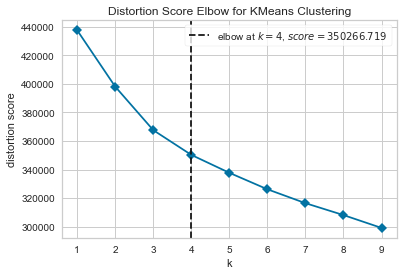

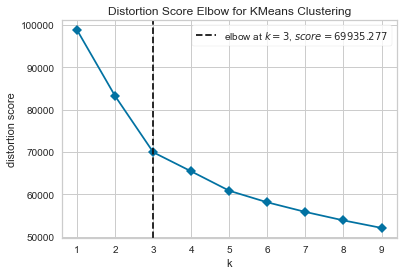

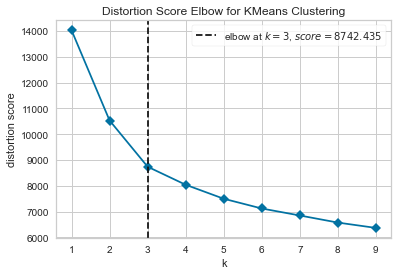

In [10]:
for i in [X_small, X_medium, X_big]:
    KM_baseline = KMeans(random_state=seed, n_init=10)
    # Elbow Method
    visualizer = KElbowVisualizer(KM_baseline,  k=(1,10), timings = False)
    visualizer.fit(i)
    visualizer.show(); 

### 1.2: Run K Means for each size category

#### 1.2.1 Small Cities

In [11]:
# Create a KMeans object with the number of clusters based on the elbow plot
kmeans_small = KMeans(n_clusters=4, random_state=seed)

# Fit the KMeans model to the data
kmeans_small.fit(X_small)

# Get the clusters for each city
labels_small = kmeans_small.labels_

# Get the silhouette score for the kmeans model
ss_small = silhouette_score(X_small, labels_small)

X_small_clusters = X_small.copy()
X_small_clusters['clusters'] = labels_small
X_small_clusters.head(5)

,log Population 2020,log Median Household Income,log Median Home Value,log Median Gross Rent,Renter Household,log Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,log Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,log Population Age 65 or more,log Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,log Workers 16 or more who Took Public Transportation to work,log Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,log Employed in Professional/Scientific/Technical Services,log Employed in Accommodation/Food Services,log Employed in Health Care/Social Assistance,log Employed in Arts/Entertainment/Recreation,log Male 16+: Private For-Profit Self-Emp Inc Bus,log Male 16+: Private Not-For-Profit Worker,log Civilian Population 18+: Veteran,log Population 35-64: Medicaid Coverage Only,log Population 35-64: No Health Insurance Coverage,log Households with No Internet Acces,log Households Receiving Food Stamps/SNAP,log Households Below the Poverty Leve,log Gross Rent 50% + of Household Income,log Owner Households by Year Moved In: 2017 or Later,log Total Vacant Housing Units,log Housing Units Built in 2014 or Later,log place,log Population 2019,Pop Chng %,log land_area,log water_area,log cases_per_100K,log deaths_per_100K,clusters
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Richland Center city, Wisconsin",0.459982,-0.450241,-0.159511,-0.533184,0.885949,0.598010,0.082702,-0.218362,-0.064037,0.375189,0.001512,0.165241,0.757629,1.084547,-0.070926,-0.244824,1.417767,0.370951,-0.648071,-0.127432,-0.027614,0.920356,0.209515,0.186483,-0.049786,-0.296150,0.375066,-0.178841,0.562454,0.454457,0.468745,0.573582,-0.665813,0.184065,-0.566148,0.441271,0.463570,-0.096689,0.482684,0.186356,-0.040080,-0.384504,0
"Wildwood city, New Jersey",0.458957,-0.398664,0.952487,0.884219,1.503504,4.403502,-0.403535,1.815293,-0.096316,0.200871,-0.777833,-0.038582,-0.442339,-0.088571,0.740839,-0.610641,2.057426,-0.228319,-1.191543,-0.776497,1.198898,-1.034223,0.194246,0.591245,-0.450879,-0.391030,1.014858,0.501768,0.042763,0.594154,0.645767,1.331288,-0.306806,2.495818,0.274946,0.608067,0.465504,-0.198898,-0.102864,0.205978,-2.118325,0.444301,0
"Alexandria city, Indiana",0.458957,0.028136,-0.540454,-0.122910,-0.207800,0.344837,0.440578,-0.421598,0.129029,-0.540921,-0.122368,-0.816825,0.122308,-0.202096,2.273087,-0.252126,1.308379,0.302384,-0.392719,0.058071,-2.455995,1.425933,-0.257550,-0.094425,0.418014,0.947725,0.390231,-0.138263,0.177632,-0.248057,0.188576,0.274962,0.381671,0.457669,-0.566148,-3.494731,0.460948,-0.040843,0.180029,-0.829496,0.121842,0.447130,0
"Midfield city, Alabama",0.458872,-0.374030,-0.581774,0.507952,0.523927,0.138281,-3.954087,0.081253,-0.029026,0.444764,0.626881,1.012633,-0.688297,-0.344088,-0.202824,-0.463476,0.000000,-2.179169,-0.496205,-0.415947,0.847157,0.636960,-0.727642,-0.869043,0.340131,-0.818859,0.370473,0.902607,0.435912,0.630879,0.516552,0.564648,-0.306756,0.341732,-0.049550,0.135235,0.469097,-0.325259,0.185233,-0.829496,0.427804,0.048060,0
"Kingsford city, Michigan",0.458786,-0.178101,-0.285480,-0.442401,0.256067,0.286174,-0.041700,-0.257635,0.454273,0.260568,0.462021,-0.125553,0.606907,0.575595,-0.889345,-0.212973,0.794435,0.009433,-0.008885,0.137846,-2.086923,0.231253,-0.167328,-0.094205,0.807754,-0.013901,0.574930,-1.467398,0.050349,0.061805,0.351739,0.663934,0.801896,-0.439476,-0.297740,0.033961,0.461287,-0.058584,0.444812,0.263651,0.752151,1.225159,0


In [12]:
# Check number of cities per cluster
np.bincount(labels_small)

array([5940,  660, 1325, 3995])

Check sample cities in each cluster

In [13]:
# specify the number of cities to take for each cluster label
num_samples = 3

# sample the data
samples = X_small_clusters.groupby('clusters').apply(lambda x: x.sample(n=num_samples))

# print the resulting samples
small_samples = [[samples.loc[i, :].index.values][0].tolist() for i in samples.index.levels[0]]
small_samples

[['Pine Grove town, West Virginia',
  'Jackson Center borough, Pennsylvania',
  'Wurtland city, Kentucky'],
 ['Alvarado city, Texas', 'Talco city, Texas', 'Sandy Oaks city, Texas'],
 ['Sandy Lake borough, Pennsylvania',
  'Garland town, North Carolina',
  'Iroquois village, Illinois'],
 ['Hospers city, Iowa', 'Albany village, Ohio', 'Silver Lake city, Kansas']]

#### 1.2.2 Medium Cities

In [14]:
# Create a KMeans object with the number of clusters based on the elbow plot
kmeans_medium = KMeans(n_clusters=3, random_state=seed)

# Fit the KMeans model to the data
kmeans_medium.fit(X_medium)

# Get the clusters for each city
labels_medium = kmeans_medium.labels_

# Get the silhouette score for the kmeans model
ss_medium = silhouette_score(X_medium, labels_medium)

X_medium_clusters = X_medium.copy()
X_medium_clusters['clusters'] = labels_medium 
X_medium_clusters.head(5)

,log Population 2020,log Median Household Income,log Median Home Value,log Median Gross Rent,Renter Household,log Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,log Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,log Population Age 65 or more,log Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,log Workers 16 or more who Took Public Transportation to work,log Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,log Employed in Professional/Scientific/Technical Services,log Employed in Accommodation/Food Services,log Employed in Health Care/Social Assistance,log Employed in Arts/Entertainment/Recreation,log Male 16+: Private For-Profit Self-Emp Inc Bus,log Male 16+: Private Not-For-Profit Worker,log Civilian Population 18+: Veteran,log Population 35-64: Medicaid Coverage Only,log Population 35-64: No Health Insurance Coverage,log Households with No Internet Acces,log Households Receiving Food Stamps/SNAP,log Households Below the Poverty Leve,log Gross Rent 50% + of Household Income,log Owner Households by Year Moved In: 2017 or Later,log Total Vacant Housing Units,log Housing Units Built in 2014 or Later,log place,log Population 2019,Pop Chng %,log land_area,log water_area,log cases_per_100K,log deaths_per_100K,clusters
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Newark city, Ohio",1.441097,-0.119599,0.111886,0.101587,0.659134,-0.098293,0.054108,-0.212091,0.196869,0.102217,0.149998,0.422128,-0.192914,-0.056472,0.538720,-0.071532,0.822494,0.131287,-0.002989,-0.048321,0.603103,0.075672,0.271171,-0.121598,0.169064,0.178969,0.528525,0.052481,-0.280368,0.422924,0.329331,0.595507,0.205584,0.091498,0.031944,0.236391,1.431727,0.111613,1.278491,0.307723,-0.210140,-0.493226,0
"Coral Gables city, Florida",1.440978,1.526928,2.470769,2.114073,0.130687,-0.250368,-0.433797,6.013822,1.621406,1.058898,-1.416103,0.907684,0.171683,-0.039988,-0.389550,0.082534,1.788861,0.805464,-0.288578,1.080856,-0.398380,-0.304598,0.209756,1.037503,0.694817,-1.817066,-1.346556,-0.181559,-1.421945,-1.045101,-0.344996,0.432092,0.320794,0.105167,0.612558,-0.981419,1.438144,-0.116928,1.024325,0.580587,1.176381,0.520061,1
"Twin Falls city, Idaho",1.439969,-0.022494,0.494237,0.240674,0.185954,-0.507230,-0.103945,1.231859,0.138410,0.413263,0.219525,-0.371960,-0.324501,-0.195629,0.913770,0.231735,0.507022,0.302303,0.278581,0.023748,0.055885,0.295673,0.155592,0.485845,0.432302,0.321944,-0.418825,0.339678,-0.361898,0.033584,0.021249,0.164179,0.658079,-0.901176,0.542988,0.626342,1.427264,0.229878,1.234454,0.204720,0.765133,0.324712,0
"Little Elm city, Texas",1.439738,1.318338,1.032022,1.922107,-0.260752,-1.263843,-1.553795,1.576447,0.828818,0.152471,0.490878,0.025822,-1.923617,-1.708038,0.573752,0.503072,0.526456,0.699721,0.339411,0.758358,0.585802,-0.239785,0.426815,0.375137,-0.192986,-0.597033,-1.009658,0.530257,-2.133355,-1.051119,-1.116240,0.179250,0.615785,-1.247798,1.151374,0.027864,1.400651,1.196785,1.194433,0.456546,-0.841062,-1.146671,2
"Kannapolis city, North Carolina",1.439704,0.183842,0.377506,0.338672,0.186010,-0.473050,-1.203674,0.965909,0.327229,0.177536,0.179214,0.030958,-0.329904,-0.724829,0.376296,0.007107,1.133941,0.404998,0.015590,0.434028,0.399433,0.156130,0.190557,-0.105644,0.419879,0.217717,-0.172296,0.259018,-0.385418,0.020140,-0.117577,0.124065,0.278461,0.004359,0.792579,-0.155254,1.424480,0.319664,1.514608,0.318377,-0.283887,-0.285316,0


In [15]:
# Check number of cities per cluster
np.bincount(labels_medium)

array([2116,  449, 1405])

In [16]:
# specify the number of cities to take for each cluster label
num_samples = 3

# sample the data
samples = X_medium_clusters.groupby('clusters').apply(lambda x: x.sample(n=num_samples))

# print the resulting samples
medium_samples = [[samples.loc[i, :].index.values][0].tolist() for i in samples.index.levels[0]]
medium_samples

[['Payette city, Idaho', 'Connersville city, Indiana', 'Coshocton city, Ohio'],
 ['Lochbuie town, Colorado',
  'Federal Heights city, Colorado',
  'Williams city, California'],
 ['Hercules city, California',
  'Mundelein village, Illinois',
  'Grosse Pointe Park city, Michigan']]

#### 1.2.3 Big Cities

In [17]:
# Create a KMeans object with the number of clusters based on the elbow plot
kmeans_big = KMeans(n_clusters=3, random_state=seed)

# Fit the KMeans model to the data
kmeans_big.fit(X_big)

# Get the clusters for each city
labels_big = kmeans_big.labels_

# Get the silhouette score for the kmeans model
ss_big = silhouette_score(X_big, labels_big)

X_big_clusters = X_big.copy()
X_big_clusters['clusters'] = labels_big 
X_big_clusters.head(5)

,log Population 2020,log Median Household Income,log Median Home Value,log Median Gross Rent,Renter Household,log Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,log Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,log Population Age 65 or more,log Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,log Workers 16 or more who Took Public Transportation to work,log Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,log Employed in Professional/Scientific/Technical Services,log Employed in Accommodation/Food Services,log Employed in Health Care/Social Assistance,log Employed in Arts/Entertainment/Recreation,log Male 16+: Private For-Profit Self-Emp Inc Bus,log Male 16+: Private Not-For-Profit Worker,log Civilian Population 18+: Veteran,log Population 35-64: Medicaid Coverage Only,log Population 35-64: No Health Insurance Coverage,log Households with No Internet Acces,log Households Receiving Food Stamps/SNAP,log Households Below the Poverty Leve,log Gross Rent 50% + of Household Income,log Owner Households by Year Moved In: 2017 or Later,log Total Vacant Housing Units,log Housing Units Built in 2014 or Later,log place,log Population 2019,Pop Chng %,log land_area,log water_area,log cases_per_100K,log deaths_per_100K,clusters
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"New York city, New York",3.624138,0.576553,2.097412,1.653279,1.635452,-0.318611,-2.530708,2.758687,0.997219,0.675130,-1.096272,1.369148,-0.302791,-0.162099,-0.042021,0.152408,3.759130,0.474457,-2.553245,0.817089,0.272184,0.561224,0.365696,0.314456,0.537086,-1.988486,0.819750,0.052513,-0.213752,0.388055,0.269285,0.940607,-0.154303,-0.223980,0.246387,0.183494,3.605278,-0.101703,2.691346,0.714814,-0.243847,0.960094,0
"Los Angeles city, California",3.306131,0.519098,2.165311,1.709109,1.231243,-0.708170,-2.135390,4.871871,1.027335,0.626088,-1.393215,1.613933,-0.611178,-0.496530,-0.115254,0.379049,2.540548,0.666381,-0.268427,0.797555,0.479498,-0.067448,0.516846,0.540147,0.238820,-1.679334,0.780508,0.461666,-0.520698,-0.221204,0.145730,0.937334,-0.087944,-0.505631,0.318282,0.048612,3.286862,-0.008355,2.927408,0.603250,-0.144416,-0.517855,1
"Chicago city, Illinois",3.141383,0.410550,1.018102,1.023038,1.186947,-0.033387,-2.197749,2.725876,1.098528,0.704106,-0.923717,1.855438,-0.639906,-0.205993,-0.108119,0.391180,3.318854,0.612533,-1.223167,0.968937,0.406219,0.177102,0.307061,0.271971,0.616383,-1.388815,0.456966,0.339190,-0.124801,0.359082,0.278685,0.719390,0.113543,-0.006228,0.310995,-0.997589,3.125560,-0.087479,2.543771,0.491761,0.296237,0.339581,0
"Houston city, Texas",3.075599,0.091995,0.569303,0.872861,1.151612,-0.273297,-1.999697,4.475036,0.672988,0.675685,-1.039067,1.004736,-0.932315,-0.605667,0.205911,0.232441,1.988287,0.355922,0.017546,0.706981,0.379279,-0.278616,0.124711,0.210406,0.126515,-1.085200,-0.114012,0.997301,-0.174980,0.125746,0.270372,0.744655,0.075322,-0.075390,0.711080,-0.160459,3.058139,-0.014028,3.092355,0.598117,-0.629083,-0.704889,1
"Phoenix city, Arizona",2.933779,0.368909,0.937149,0.904534,0.418083,-0.739073,-1.131387,4.273558,0.456140,0.500300,-0.596011,0.827527,-0.934436,-0.642860,0.362118,0.344294,1.811297,0.589014,-0.040566,0.623335,0.460832,-0.086986,0.211307,0.315140,0.207753,-0.441910,0.413457,0.598897,-0.487422,-0.083628,-0.063953,0.402678,0.282803,-0.511076,0.398342,0.252478,2.911313,0.197762,2.979783,0.373843,0.237074,0.163452,1


In [18]:
# Check number of cities per cluster
np.bincount(labels_big)

array([319, 175, 281])

In [19]:
# specify the number of cities to take for each cluster label
num_samples = 3

# sample the data
samples = X_big_clusters.groupby('clusters').apply(lambda x: x.sample(n=num_samples))

# print the resulting samples
big_samples = [[samples.loc[i, :].index.values][0].tolist() for i in samples.index.levels[0]]
big_samples

[['Cape Coral city, Florida',
  'Bossier City city, Louisiana',
  'Waukesha city, Wisconsin'],
 ['Las Cruces city, New Mexico',
  'Lodi city, California',
  'Harlingen city, Texas'],
 ['Round Rock city, Texas',
  'Redwood City city, California',
  'Milpitas city, California']]

### 1.3: Results

In [20]:
# create dictionary of results
res = {"Models": ["for small cities", "for medium cities", "for big cities"], 
        "Number of clusters": [len(np.bincount(labels_small)), len(np.bincount(labels_medium)), len(np.bincount(labels_big))], 
        "Size of each cluster": [np.bincount(labels_small), np.bincount(labels_medium), np.bincount(labels_big)],
        "Silhouette Score": [ss_small, ss_medium, ss_big]}
        # "sample cities in each cluster": [small_samples, medium_samples, big_samples]}

# convert dictionary to DataFrame
df_res = pd.DataFrame(res)
df_res.style.background_gradient(cmap='Blues')

,Models,Number of clusters,Size of each cluster,Silhouette Score
0,for small cities,4,[5940 660 1325 3995],0.094727
1,for medium cities,3,[2116 449 1405],0.194146
2,for big cities,3,[319 175 281],0.203877


Models for big cities and medium cities are better than models for small cities. We will try other models to check the results.

# Model 2: Hierarchical clustering

#### 2.1 Plot different linkage methods

2.1.1 Complete Linkage

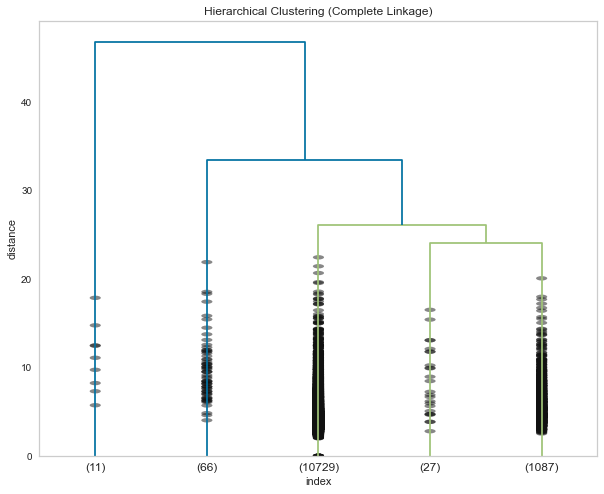

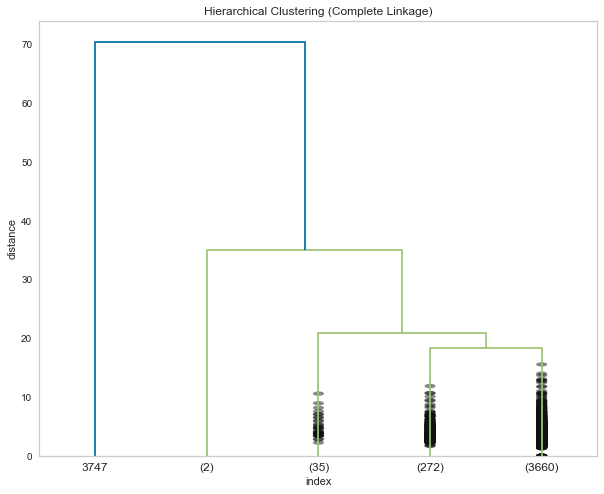

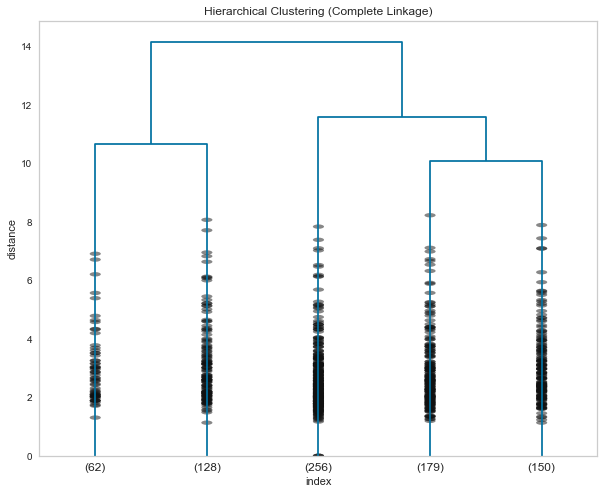

In [21]:
# Plot dendrogram
for i in [X_small, X_medium, X_big]:
        compl=linkage(i,"complete")
        plt.figure(figsize=(10,8))
        plt.grid(visible=None)
        plt.title("Hierarchical Clustering (Complete Linkage)")
        plt.xlabel("index")
        plt.ylabel("distance")
        dendrogram(compl, truncate_mode="lastp",p=5,show_contracted=True)
        plt.show()

2.1.2 Average Linkage

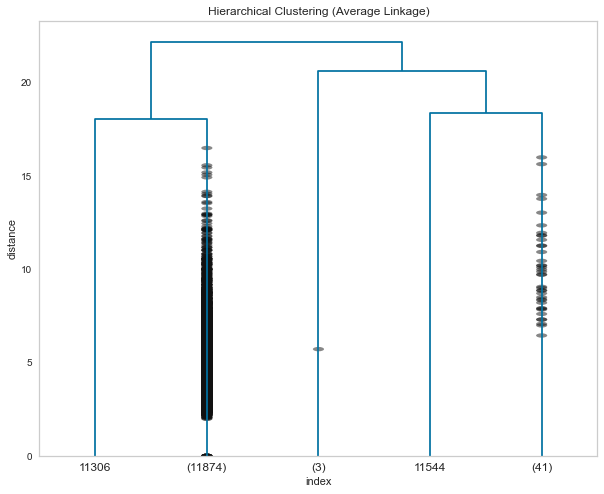

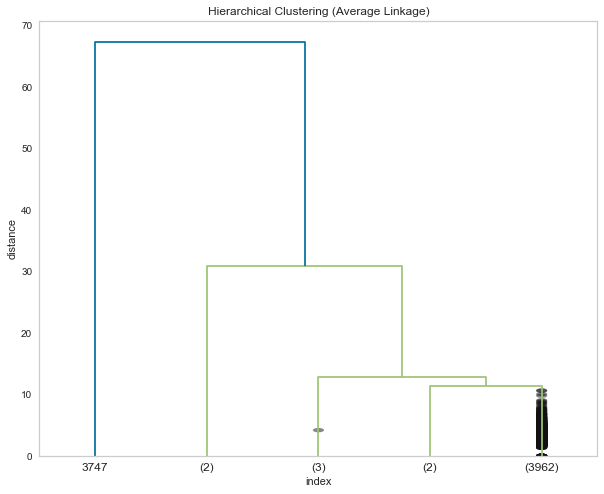

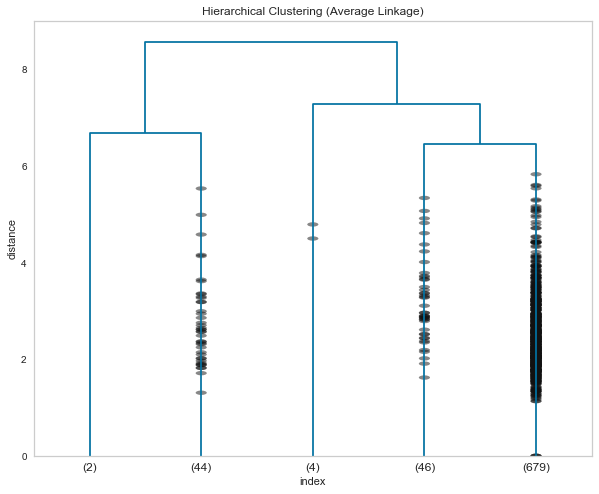

In [22]:
# Plot dendrogram
for i in [X_small, X_medium, X_big]:
        compl=linkage(i,"average")
        plt.figure(figsize=(10,8))
        plt.grid(visible=None)
        plt.title("Hierarchical Clustering (Average Linkage)")
        plt.xlabel("index")
        plt.ylabel("distance")
        dendrogram(compl, truncate_mode="lastp",p=5,show_contracted=True);
        plt.show()

2.1.3 Ward Linkage

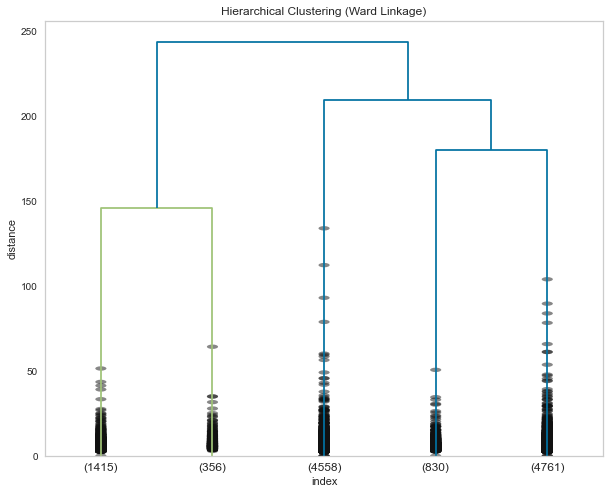

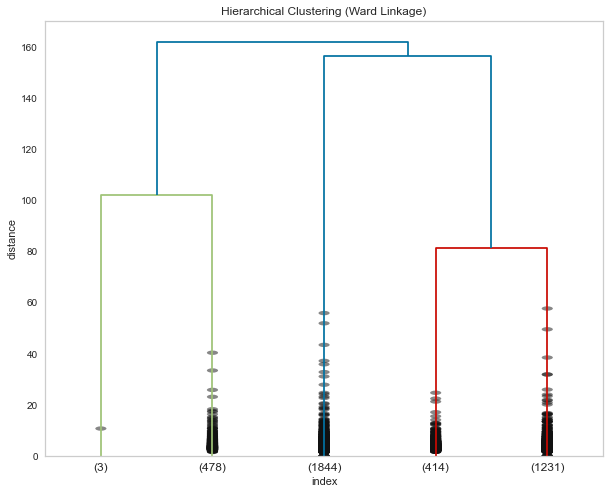

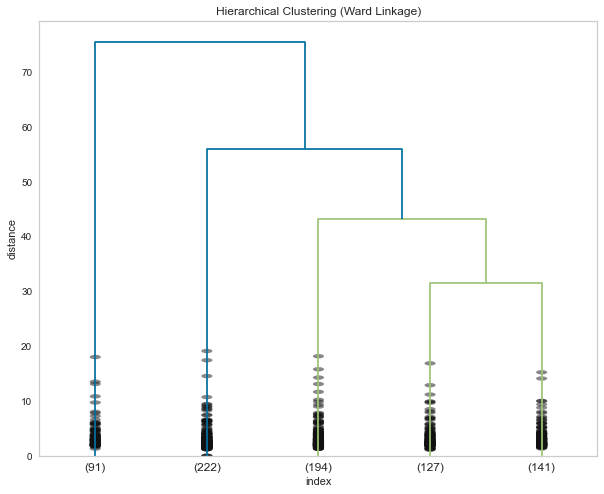

In [23]:
# Plot dendrogram
for i in [X_small, X_medium, X_big]:
        compl=linkage(i,"ward")
        plt.figure(figsize=(10,8))
        plt.grid(visible=None)
        plt.title("Hierarchical Clustering (Ward Linkage)")
        plt.xlabel("index")
        plt.ylabel("distance")
        dendrogram(compl, truncate_mode="lastp",p=5,show_contracted=True);
        plt.show()

We will check the results for different affinity methods.

#### 2.2.1 Small Cities

In [24]:
hc_small =AgglomerativeClustering(n_clusters=5, linkage='ward')
clusters_small = hc_small.fit_predict(X_small)

# Get the silhouette score for the kmeans model
ss_small_hc = silhouette_score(X_small, clusters_small)

In [25]:
X_small_hc = X_small.copy()
X_small_hc['clusters'] = clusters_small

In [26]:
# specify the number of cities to take for each cluster label
num_samples = 3

# sample the data
samples = X_small_hc.groupby('clusters').apply(lambda x: x.sample(n=num_samples))

# print the resulting samples
small_samples = [[samples.loc[i, :].index.values][0].tolist() for i in samples.index.levels[0]]
small_samples

[['Black Earth village, Wisconsin',
  'Crystal City city, Missouri',
  'Humboldt town, South Dakota'],
 ['Escalante city, Utah',
  'La Fayette city, Alabama',
  'East Rochester borough, Pennsylvania'],
 ['Bethune town, South Carolina',
  'Alex town, Oklahoma',
  'Pineland city, Texas'],
 ['Rolla city, Kansas', 'Kimberly city, Idaho', 'Harriman village, New York'],
 ['Doniphan city, Missouri',
  'Wardner city, Idaho',
  'Sheridan village, Michigan']]

#### 2.2.2 Medium Cities

In [27]:
hc_medium =AgglomerativeClustering(n_clusters=3, linkage='ward')
clusters_medium = hc_medium.fit_predict(X_medium)

# Get the silhouette score for the kmeans model
ss_medium_hc = silhouette_score(X_medium, clusters_medium)

X_medium_hc = X_medium.copy()
X_medium_hc['clusters'] = clusters_medium

In [28]:
# specify the number of cities to take for each cluster label
num_samples = 3

# sample the data
samples = X_medium_hc.groupby('clusters').apply(lambda x: x.sample(n=num_samples))

# print the resulting samples
medium_samples = [[samples.loc[i, :].index.values][0].tolist() for i in samples.index.levels[0]]
medium_samples

[['Bridgeport city, Texas',
  'Lindsay city, California',
  'De Queen city, Arkansas'],
 ['Loveland city, Ohio',
  'Bridgeport city, West Virginia',
  'Pigeon Forge city, Tennessee'],
 ['Harvey city, Illinois',
  'Greenville city, Michigan',
  'Charlestown city, Indiana']]

#### 2.2.3 Big Cities

In [29]:
hc_big =AgglomerativeClustering(n_clusters=4, linkage='ward')
clusters_big= hc_big.fit_predict(X_big)

# Get the silhouette score for the kmeans model
ss_big_hc = silhouette_score(X_big, clusters_big)

X_big_hc = X_big.copy()
X_big_hc['clusters'] = clusters_big

In [30]:
# specify the number of cities to take for each cluster label
num_samples = 3

# sample the data
samples = X_big_hc.groupby('clusters').apply(lambda x: x.sample(n=num_samples))

# print the resulting samples
big_samples = [[samples.loc[i, :].index.values][0].tolist() for i in samples.index.levels[0]]
big_samples

[['Evanston city, Illinois',
  'Minneapolis city, Minnesota',
  'Kansas City city, Kansas'],
 ['Moore city, Oklahoma',
  'Logan city, Utah',
  'Summerville town, South Carolina'],
 ['Jupiter town, Florida',
  'Omaha city, Nebraska',
  'Columbia city, South Carolina'],
 ['Pharr city, Texas', 'Edinburg city, Texas', 'Miami Beach city, Florida']]

### 2.4 Results

In [31]:
# create dictionary of results
res = {"Models": ["for small cities", "for medium cities", "for big cities"], 
        "Number of clusters": [len(np.bincount(clusters_small)), len(np.bincount(clusters_medium)), len(np.bincount(clusters_big))], 
        "Size of each cluster": [np.bincount(clusters_small), np.bincount(clusters_medium), np.bincount(clusters_big)],
        "Silhouette Score": [ss_small_hc, ss_medium_hc, ss_big_hc]}
        # "sample cities in each cluster": [small_samples, medium_samples, big_samples]}

# convert dictionary to DataFrame
df_res = pd.DataFrame(res)
df_res.style.background_gradient(cmap='Blues')

,Models,Number of clusters,Size of each cluster,Silhouette Score
0,for small cities,5,[4558 4761 356 830 1415],0.048559
1,for medium cities,3,[ 481 1645 1844],0.155736
2,for big cities,4,[268 194 222 91],0.138293


According to the silhouette scores, the results are worse than k-means clustering.

# Model 3: DBSCAN

We like to try DBSCAN since it can handle high-dimensional data well. Besides, it is good at handling noise and outliers. We will use silhouette score to find the best parameters for each size category.

For min_samples, we will use min_samples = 2*dim, where dim= the dimensions of our data set (Sander et al., 1998).

#### 3.1 Small Cities

In [32]:
neighbors = NearestNeighbors(n_neighbors=2*len(X_small.columns))
neighbors_fit = neighbors.fit(X_small)
dist, idx = neighbors_fit.kneighbors(X_small)

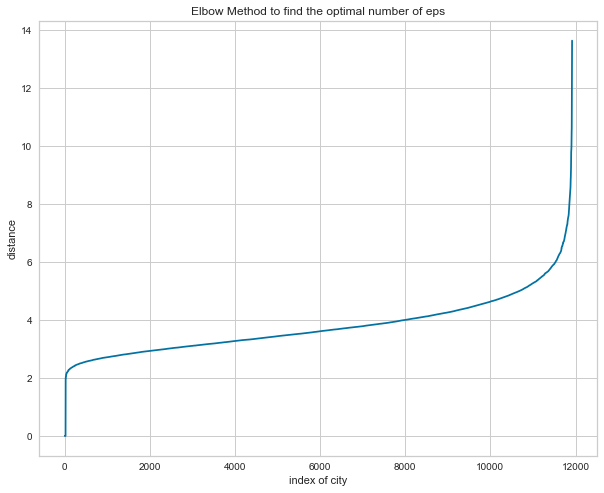

In [33]:
distances = np.sort(dist, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.xlabel("index of city")
plt.ylabel("distance")
plt.title("Elbow Method to find the optimal number of eps")
plt.plot(distances)
plt.show()

The ideal value for eps equals to the distance value at the elbow (the point of maximum curvature). It is around 5 here.

Fit DBSCAN with the best combination of eps and min_samples

In [34]:
dbscan = DBSCAN(min_samples=2*len(X_small.columns), eps=5)
clusters_small = dbscan.fit_predict(X_small)

In [35]:
X_small_db = X_small.copy()
X_small_db['clusters'] = clusters_small
X_small_db['clusters'].value_counts()

 0    10072
-1     1848
Name: clusters, dtype: int64

Sample cities in each cluster

In [36]:
# specify the number of cities to take for each cluster label
num_samples = 3

# sample the data
samples = X_small_db.groupby('clusters').apply(lambda x: x.sample(n=num_samples))

# print the resulting samples
small_samples = [[samples.loc[i, :].index.values][0].tolist() for i in samples.index.levels[0]]
small_samples

[['Lyman town, Washington',
  'Mesa city, Washington',
  'Chunky town, Mississippi'],
 ['Wilson village, Wisconsin',
  'Hildreth village, Nebraska',
  'Hills city, Minnesota']]

#### 3.2 Medium Cities

In [37]:
neighbors = NearestNeighbors(n_neighbors=2*len(X_medium.columns))
neighbors_fit = neighbors.fit(X_medium)
dist, idx = neighbors_fit.kneighbors(X_medium)

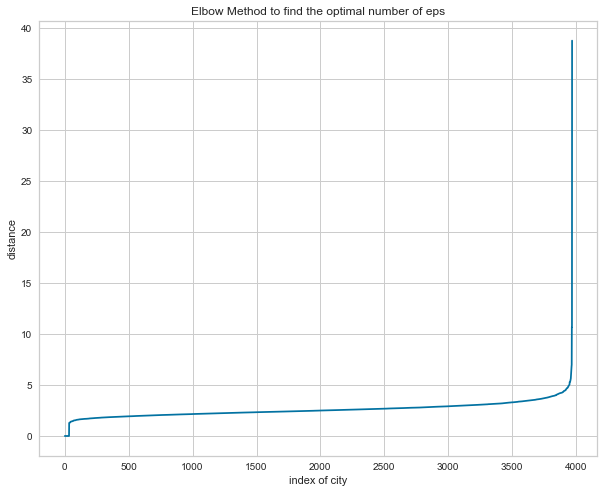

In [38]:
distances = np.sort(dist, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.xlabel("index of city")
plt.ylabel("distance")
plt.title("Elbow Method to find the optimal number of eps")
plt.plot(distances)
plt.show()

In [39]:
dbscan = DBSCAN(min_samples=2*len(X_medium.columns), eps=4)
clusters_medium = dbscan.fit_predict(X_medium)

In [40]:
X_medium_db = X_medium.copy()
X_medium_db['clusters'] = clusters_medium
X_medium_db['clusters'].value_counts()

 0    3632
-1     338
Name: clusters, dtype: int64

In [41]:
# specify the number of cities to take for each cluster label
num_samples = 3

# sample the data
samples = X_medium_db.groupby('clusters').apply(lambda x: x.sample(n=num_samples))

# print the resulting samples
medium_samples = [[samples.loc[i, :].index.values][0].tolist() for i in samples.index.levels[0]]
medium_samples

[['Williams city, California',
  'San Juan city, Texas',
  'Wasco city, California'],
 ['Maryland Heights city, Missouri',
  'Union city, South Carolina',
  'Scott city, Louisiana']]

#### 3.3 Big Cities

In [42]:
neighbors = NearestNeighbors(n_neighbors=2*len(X_big.columns))
neighbors_fit = neighbors.fit(X_big)
dist, idx = neighbors_fit.kneighbors(X_big)

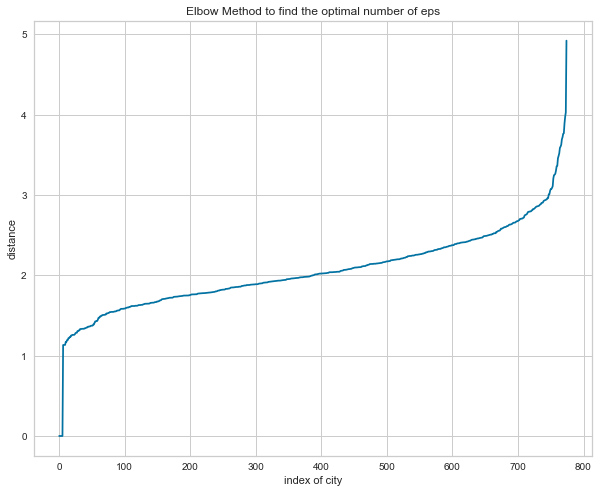

In [43]:
distances = np.sort(dist, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.xlabel("index of city")
plt.ylabel("distance")
plt.title("Elbow Method to find the optimal number of eps")
plt.plot(distances)
plt.show()

In [44]:
dbscan = DBSCAN(min_samples=2*len(X_big.columns), eps=2.8)
clusters_big = dbscan.fit_predict(X_big)

In [45]:
X_big_db = X_big.copy()
X_big_db['clusters'] = clusters_big
X_big_db['clusters'].value_counts()

-1    616
 0    159
Name: clusters, dtype: int64

In [46]:
# specify the number of cities to take for each cluster label
num_samples = 3

# sample the data
samples = X_big_db.groupby('clusters').apply(lambda x: x.sample(n=num_samples))

# print the resulting samples
big_samples = [[samples.loc[i, :].index.values][0].tolist() for i in samples.index.levels[0]]
big_samples

[['Mountain View city, California',
  'Queen Creek town, Arizona',
  'Leesburg town, Virginia'],
 ['Jackson city, Tennessee',
  'Billings city, Montana',
  'Rocky Mount city, North Carolina']]

### 3.4 Results

DBSCAN is not finding any clusters. Therefore, there is no result to compare in terms of silhouette score.

# Model 4: Gaussian Mixture Model (GMM)

We will use GMM as it allows for clusters with arbitrary shapes and sizes. To estimate the optimal number of clusters, we will use Bayesian Information Criterion (BIC) as it is a good indicator of the model's complexity.

#### 4.1 Small Cities

In [47]:
# create GMM models with different number of components
n_components = np.arange(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=0) for n in n_components]

# compute the BIC score for each model
bics = [model.fit(X_small).bic(X_small) for model in models]

# estimate the optimal number of clusters 
n_clusters = n_components[np.argmin(bics)] # find the index of the minimum BIC score
print("The optimal number of clusters is {}".format(n_clusters))

The optimal number of clusters is 9


In [48]:
# create a GMM with the optimal number of clusters
gmm = GaussianMixture(n_components=n_clusters)
gmm.fit(X_small)
clusters_small = gmm.predict(X_small)

# Get the silhouette score
ss_small_gmm = silhouette_score(X_small, clusters_small)

In [49]:
X_small_gmm = X_small.copy()
X_small_gmm['clusters'] = clusters_small

In [50]:
# specify the number of cities to take for each cluster label
num_samples = 3

# sample the data
samples = X_small_gmm.groupby('clusters').apply(lambda x: x.sample(n=num_samples))

# print the resulting samples
small_samples = [[samples.loc[i, :].index.values][0].tolist() for i in samples.index.levels[0]]
small_samples

[['McConnellsburg borough, Pennsylvania',
  'Colon village, Michigan',
  'Loogootee city, Indiana'],
 ['Squaw Lake city, Minnesota',
  'Old Harbor city, Alaska',
  'Silver City town, Mississippi'],
 ['Glendora village, Mississippi',
  'Medora town, Indiana',
  "Parker's Crossroads city, Tennessee"],
 ['Dalton city, Minnesota',
  'Hildreth village, Nebraska',
  'Hatton city, North Dakota'],
 ['Wortham town, Texas',
  'Waco town, North Carolina',
  'Galatia village, Illinois'],
 ['Grantfork village, Illinois', 'Alta town, Utah', 'Fairfield city, Idaho'],
 ['North Braddock borough, Pennsylvania',
  'Woodburn city, Kentucky',
  'San Joaquin city, California'],
 ['Clayton village, New York',
  'Alton city, Missouri',
  'Oxford village, Michigan'],
 ['Oakwood Hills village, Illinois',
  'Spring Lake borough, New Jersey',
  'Riverdale borough, New Jersey']]

#### 4.2 Medium Cities

In [52]:
# create GMM models with different number of components
n_components = np.arange(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=0) for n in n_components]

# compute the BIC score for each model
bics_medium = [model.fit(X_medium).bic(X_medium) for model in models]

# estimate the optimal number of clusters 
n_clusters_medium = n_components[np.argmin(bics_medium)] # find the index of the minimum BIC score
print("The optimal number of clusters is {}".format(n_clusters_medium))

The optimal number of clusters is 4


In [53]:
# create a GMM with the optimal number of clusters
gmm = GaussianMixture(n_components=n_clusters_medium)
gmm.fit(X_medium)
clusters_medium = gmm.predict(X_medium)

# Get the silhouette score
ss_medium_gmm = silhouette_score(X_medium, clusters_medium)

In [54]:
X_medium_gmm = X_medium.copy()
X_medium_gmm['clusters'] = clusters_medium

In [55]:
# specify the number of cities to take for each cluster label
num_samples = 1

# sample the data
samples = X_medium_gmm.groupby('clusters').apply(lambda x: x.sample(n=num_samples))

# print the resulting samples
medium_samples = [[samples.loc[i, :].index.values][0].tolist() for i in samples.index.levels[0]]
medium_samples

[['Fox Point village, Wisconsin'],
 ['Bridgeview village, Illinois'],
 ['Chadron city, Nebraska'],
 ['Shelbyville city, Indiana']]

#### 4.3 Big Cities

In [58]:
# create GMM models with different number of components
n_components = np.arange(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=0) for n in n_components]

# compute the BIC score for each model
bics_big = [model.fit(X_big).bic(X_big) for model in models]

# estimate the optimal number of clusters 
n_clusters_big = n_components[np.argmin(bics_big)] # find the index of the minimum BIC score
print("The optimal number of clusters is {}".format(n_clusters_big))

The optimal number of clusters is 1


In [60]:
# create a GMM with the optimal number of clusters
gmm = GaussianMixture(n_components=n_clusters_big)
gmm.fit(X_big)
clusters_big = gmm.predict(X_big)

# Get the silhouette score
if len(np.unique(clusters_big)) == 1:
    ss_big_gmm = "not enough clusters"
else:
    ss_big_gmm = silhouette_score(X_big, clusters_big)

In [61]:
X_big_gmm = X_big.copy()
X_big_gmm['clusters'] = clusters_big

In [62]:
# specify the number of cities to take for each cluster label
num_samples = 3

# sample the data
samples = X_big_gmm.groupby('clusters').apply(lambda x: x.sample(n=num_samples))

# print the resulting samples
big_samples = [[samples.loc[i, :].index.values][0].tolist() for i in samples.index.levels[0]]
big_samples

[['Marysville city, Washington',
  'DeSoto city, Texas',
  'St. Cloud city, Minnesota']]

### 4.4 Results

In [63]:
# create dictionary of results
res = {"Models": ["for small cities", "for medium cities", "for big cities"], 
        "Number of clusters": [len(np.bincount(clusters_small)), len(np.bincount(clusters_medium)), len(np.bincount(clusters_big))], 
        "Size of each cluster": [np.bincount(clusters_small), np.bincount(clusters_medium), np.bincount(clusters_big)],
        "Silhouette Score": [ss_small_gmm, ss_medium_hc, ss_big_gmm]}

# convert dictionary to DataFrame
df_res = pd.DataFrame(res)
df_res.style.background_gradient(cmap='Blues')

,Models,Number of clusters,Size of each cluster,Silhouette Score
0,for small cities,9,[4569 282 133 560 3615 480 738 947 596],-0.054288
1,for medium cities,4,[ 245 1377 884 1464],0.155736
2,for big cities,1,[775],not enough clusters


# 5. Final Results

We use silhouette score to compare the results of different models, and to find the best model for each size category.

In [64]:
# create dictionary of results
res = {"Models for": ["small cities", "medium cities", "big cities"], 
        "K-means": [ss_small, ss_medium, ss_big], 
        "Hierarchical clustering": [ss_small_hc, ss_medium_hc, ss_big_hc],
        # "DBSCAN": [ss_small_hc, ss_medium_hc, ss_big_hc],
        "GMM": [ss_small_gmm, ss_medium_gmm, ss_big_gmm]}

# convert dictionary to DataFrame
df_res = pd.DataFrame(res)
df_res.style.background_gradient(cmap='Blues')

,Models for,K-means,Hierarchical clustering,GMM
0,small cities,0.094727,0.048559,-0.054288
1,medium cities,0.194146,0.155736,0.071209
2,big cities,0.203877,0.138293,not enough clusters


### How about Pittsburgh?

We will use the results from the best model for each size category to see which cluster Pittsburgh belongs to and what other cities are in the same cluster.

In [77]:
X_big_clusters[X_big_clusters.index.values =='Pittsburgh city, Pennsylvania']

,log Population 2020,log Median Household Income,log Median Home Value,log Median Gross Rent,Renter Household,log Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,log Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,log Population Age 65 or more,log Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,log Workers 16 or more who Took Public Transportation to work,log Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,log Employed in Professional/Scientific/Technical Services,log Employed in Accommodation/Food Services,log Employed in Health Care/Social Assistance,log Employed in Arts/Entertainment/Recreation,log Male 16+: Private For-Profit Self-Emp Inc Bus,log Male 16+: Private Not-For-Profit Worker,log Civilian Population 18+: Veteran,log Population 35-64: Medicaid Coverage Only,log Population 35-64: No Health Insurance Coverage,log Households with No Internet Acces,log Households Receiving Food Stamps/SNAP,log Households Below the Poverty Leve,log Gross Rent 50% + of Household Income,log Owner Households by Year Moved In: 2017 or Later,log Total Vacant Housing Units,log Housing Units Built in 2014 or Later,log place,log Population 2019,Pop Chng %,log land_area,log water_area,log cases_per_100K,log deaths_per_100K,clusters
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Pittsburgh city, Pennsylvania",2.206925,-0.035435,0.161967,0.628973,1.547088,0.602139,-1.228531,-0.060305,1.026848,1.092794,-0.913994,2.483318,-0.29621,0.229697,-0.423277,0.574638,3.050344,0.684886,-0.847224,0.893204,0.443119,0.711124,0.354213,0.124006,1.17234,-0.306498,0.183684,-0.427431,0.021963,0.427387,0.618115,0.870849,0.045401,0.174615,0.396052,0.347074,2.19747,-0.076867,1.795284,0.434044,-0.907333,-0.256205,0


Pittsburgh is in cluster 0. We will check the cities in the same cluster.

In [92]:
pit_cluster = X_big_clusters[X_big_clusters['clusters'] == 0]
d = np.array(pit_cluster.index.values)

In [93]:
cities = [i for i in d]
cities[:5]

['New York city, New York',
 'Chicago city, Illinois',
 'Philadelphia city, Pennsylvania',
 'Jacksonville city, Florida',
 'Columbus city, Ohio']

These are the cities in the same cluster as Pittsburgh. From this, we can tell that Pittsburgh shares similarities with these cities. This can be a good reference for city development and for people who are interested in moving in or out of Pittsburgh.

# 6. Conclusion and Future Work

We used the silhouette score to evaluate the performance of each model.
K-means clustering performed the best among all these models. DBSCAN and Gaussian Mixture Model seemed to be having trouble with finding the optimal number of clusters.

To take a closer look at the results, we will check the sample cities in each cluster for each size category. 
Because k-mean performed the best, we will show the results for k-means clustering:

**Small cities**
- Cluster 1: 'Pine Grove town, West Virginia', 'Jackson Center borough, Pennsylvania', 'Wurtland city, Kentucky'
- Cluster 2: 'Alvarado city, Texas', 'Talco city, Texas', 'Sandy Oaks city, Texas'
- Cluster 3: ‘Sandy Lake borough, Pennsylvania', 'Garland town, North Carolina', 'Iroquois village, Illinois'
- Cluster 4: 'Hospers city, Iowa', 'Albany village, Ohio', 'Silver Lake city, Kansas'

**Medium cities** 
- Cluster 1: ‘Payette city, Idaho', 'Connersville city, Indiana', 'Coshocton city, Ohio'
- Cluster 2: ‘Lochbuie town, Colorado', 'Federal Heights city, Colorado',  'Williams city, California'
- Cluster 3:  ‘Hercules city, California', 'Mundelein village, Illinois', 'Grosse Pointe Park city, Michigan'

**Big cities**
- Cluster 1: 'Cape Coral city, Florida', 'Bossier City city, Louisiana', 'Waukesha city, Wisconsin’
- Cluster 2: 'Las Cruces city, New Mexico', 'Lodi city, California',’Harlingen city, Texas'
- Cluster 3: 'Round Rock city, Texas', 'Redwood City city, California', 'Milpitas city, California'

We also include the cities in the same cluster as Pittsburgh, such as New York City, Chicago, and Philadelphia. One can use the results to find cities that are similar to Pittsburgh, and use the information to make decisions in terms of where to live, where to start a business, etc. 

For future work, we would like to try other clustering models, such as spectral clustering and affinity propagation. Besides, if possible, we can include crime data and political data on the city level to see if we can find other patterns.

# References
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html 
- In class exercises week 12, 13, 14
- https://stackoverflow.com/questions/53310228/how-can-i-make-seaborn-distribution-subplots-in-a-loop
- https://stackabuse.com/bytes/agglomerative-hierarchical-clustering-with-scikit-learn/
- https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/
- https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c
- https://stackoverflow.com/questions/58983528/how-to-find-optimal-parametrs-for-dbscan
- https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
- https://link.springer.com/article/10.1023/A:1009745219419